In [7]:
import cv2
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy as np
import time
import random
import pickle
import seaborn

import tensorflow as tf

import keras
import keras.backend as K
from keras.layers import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model


#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn 

import warnings
warnings.filterwarnings('ignore')

print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0-rc2
Keras version: 2.3.1
GPU is NOT AVAILABLE


## Model Load

In [3]:
#Model
num_classes=2

base_model = efn.EfficientNetB0(include_top=False, weights=None, classes=num_classes)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.load_weights('../models/efficientnet_b0_aug_last_weights_120_best.h5')

In [4]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

# MY Gradient class activation map (GRAD CAM)

## Prediction

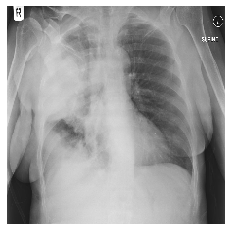

[[0.00709998 0.9929    ]]
bestclass covid19
1


In [8]:
#covid19
my_test_path = "../datasets/test_images/covid19/23E99E2E-447C-46E5-8EB2-D35D12473C39.png"
my_test_path = "../datasets/test_images/covid19/ciaa199.pdf-001-c.png"
my_test_path = "../datasets/test_images/covid19/streptococcus-pneumoniae-pneumonia-1.jpg"


target_size = (224, 224)

img_orj = cv2.imread(my_test_path)
img_orj = cv2.resize(img_orj, target_size)

b,g,r = cv2.split(img_orj)       # get b,g,r
img2 = cv2.merge([r,g,b])

plt.imshow(img2)
plt.axis('off')
plt.show()

img2 = np.array(img2, dtype="float") / 255.0
data2 = np.expand_dims(img2, axis=0)

result_pred = model.predict(data2, batch_size=1) 
print(result_pred)

labels = ["normal", "covid19"]
bestclass = labels[np.argmax(result_pred, axis=1)[0]]
print("bestclass", bestclass)

argmax = np.argmax(result_pred, axis=1)[0]
print(argmax)


## GRAD CAM

Text(0.5, 1.0, 'COVID19')

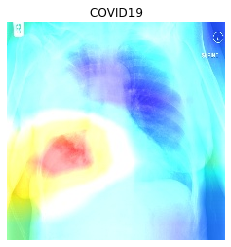

In [11]:
output = model.output[:, argmax]
#last_conv_layer = model.get_layer('block2a_expand_conv')
last_conv_layer = model.get_layer('top_conv')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([data2])

    
for i in range(last_conv_layer.output.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


heatmap = cv2.resize(heatmap, (img_orj.shape[1], img_orj.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = .8
superimposed_img = heatmap * hif + img_orj

output = 'gradcam/gradcam.jpg'

cv2.imwrite(output, superimposed_img)

img_output = mpimg.imread(output)

plt.imshow(img_output)
plt.axis('off')
plt.title(bestclass.upper())